<a href="https://colab.research.google.com/github/rtnaka/ai-quest2021_assessment/blob/main/PBL01_sample_code_%E6%94%B9%E5%A4%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import library

In [1]:
!pip install japanize-matplotlib
!pip install category_encoders

In [2]:
from itertools import product
from datetime import datetime

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import japanize_matplotlib 

import category_encoders as ce

from lightgbm import LGBMRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# read data

In [3]:
# Google DriveをColabにマウント
from google.colab import drive
drive.mount('/content/drive')

#　filepath
basepath = '/content/drive/MyDrive/AI Quest2021/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
sales = pd.read_csv(basepath+'sales_history.csv',parse_dates=["日付"])
cats = pd.read_csv(basepath+'item_categories.csv')
cat_names = pd.read_csv(basepath+'category_names.csv')
test = pd.read_csv(basepath+'test.csv',index_col=0)
sub = pd.read_csv(basepath+'sample_submission.csv', header=None)

In [5]:
#最大表示行数指定
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

# Preprocess

### merge table

In [6]:
#category_names 　→　大カテゴリ/小カテゴリに分割
split_catname = cat_names["商品カテゴリ名"].str.split("-",expand=True)
cat_names = pd.concat([cat_names,split_catname],axis=1)
cat_names.drop("商品カテゴリ名",axis=1,inplace=True)
cat_names.rename(columns={0: '商品大カテゴリ', 1: '商品小カテゴリ'},inplace=True)
cat_names.head()

,商品カテゴリID,商品大カテゴリ,商品小カテゴリ
0,100,映画,DVD
1,110,PCゲーム,通常版
2,120,音楽,その他
3,130,ゲーム,ゲーム機C
4,140,映画,ブルーレイ


In [7]:
#「sales_history.csv」、「item_category.csv」、「category_names.csv」の3つのテーブルを統合
sales = pd.merge(sales, cats, on='商品ID', how='left')
sales = pd.merge(sales, cat_names, on='商品カテゴリID', how='left')
sales.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ
0,2018-01-01,9,1000001,420,1.0,100,映画,DVD
1,2018-01-01,6,1000001,420,1.0,100,映画,DVD
2,2018-01-01,10,1000001,420,1.0,100,映画,DVD
3,2018-01-01,0,1000017,250,1.0,100,映画,DVD
4,2018-01-01,1,1000017,250,1.0,100,映画,DVD


### add columns

In [8]:
# 日付列から年と月を抽出し、新たな列とする
sales['年'] = sales['日付'].dt.year
sales['月'] = sales['日付'].dt.month
sales['四半期'] = sales['日付'].dt.quarter

In [9]:
# 「年」と「月」の全組み合わせを作成する
gp_time = sales.groupby(['年','月','四半期']).count().reset_index()[['年', '月','四半期']]
# カラム名「月ブロック」として、通し番号をつける
gp_time['月ブロック'] = list(range(len(gp_time)))

# 2019年12月(月ブロック: 23)のレコードを追加する
gp_time = gp_time.append({
    '月ブロック': 23,
    '年': 2019,
    '月': 12,
    '四半期':4
}, ignore_index=True)

In [10]:
# 「月ブロック」カラムをsalesに統合する
sales = pd.merge(sales, gp_time, on=['年', '月','四半期'], how='left')

In [11]:
#売上金額を追加
sales["売上金額"] = sales.商品価格 * sales.売上個数

In [12]:
#商品価格をbiningし、価格帯として列作成
price_bin = pd.DataFrame(pd.cut(sales.商品価格, [0, 300,500,750,1000,2000,3000,10000],labels=False))
price_bin.columns = ["価格帯"]
sales = pd.concat([sales,price_bin],axis=1)

In [13]:
sales.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期,月ブロック,売上金額,価格帯
0,2018-01-01,9,1000001,420,1.0,100,映画,DVD,2018,1,1,0,420.0,1.0
1,2018-01-01,6,1000001,420,1.0,100,映画,DVD,2018,1,1,0,420.0,1.0
2,2018-01-01,10,1000001,420,1.0,100,映画,DVD,2018,1,1,0,420.0,1.0
3,2018-01-01,0,1000017,250,1.0,100,映画,DVD,2018,1,1,0,250.0,0.0
4,2018-01-01,1,1000017,250,1.0,100,映画,DVD,2018,1,1,0,250.0,0.0


### extract 

In [14]:
# #需要予測対象の170商品の抜き出し
product_id = test["商品ID"].unique()

sales_all = sales.copy()
sales = sales[sales["商品ID"].isin(product_id)]

In [15]:
sales.商品ID.nunique()

170

# EDA

In [16]:
# 2018年に販売実績のある商品数
items_2018 = sales[sales["日付"] < datetime(2019, 1, 1)]["商品ID"].unique()
# 2019年に販売実績のある商品数
items_2019 = sales[sales["日付"] > datetime(2018, 12, 31)]["商品ID"].unique()
# 2019年4月以降に販売実績のある商品数
items_2019_04 = sales[sales["日付"] > datetime(2019, 3, 31)]["商品ID"].unique()
# 2019年7月以降に販売実績のある商品数
items_2019_07 = sales[sales["日付"] > datetime(2019, 6, 30)]["商品ID"].unique()
# 2019年10月以降に販売実績のある商品数
items_2019_10 = sales[sales["日付"] > datetime(2019, 9, 30)]["商品ID"].unique()
#2018年１２月に販売実績のあった商品数
items_201812 = sales[(sales["日付"] > datetime(2018, 11, 30))&(sales["日付"] < datetime(2019, 1, 1))]["商品ID"].unique()
#2019年10月に販売実績のない商品ID
items_201910_notSales =  np.setdiff1d(items_2019_07, items_2019_10)
#2019年から販売開始された　or ２０１８年は実績がなかった商品
items_2019only = np.setdiff1d(items_2019, items_2018)

print("2018年販売実績あり：",len(items_2018))
print("2019年販売実績あり：",len(items_2019))
print("2019年4月以降販売実績あり：",len(items_2019_04))
print("2019年7月以降販売実績あり：",len(items_2019_07))
print("2019年10月以降販売実績あり：",len(items_2019_10))
print("2018年12月に販売実績あり：",len(items_201812))
print("2019年10月に販売実績のない商品ID",items_201910_notSales)
print("２０１８年販売実績無し",items_2019only)

2018年販売実績あり： 150
2019年販売実績あり： 170
2019年4月以降販売実績あり： 170
2019年7月以降販売実績あり： 170
2019年10月以降販売実績あり： 168
2018年12月に販売実績あり： 150
2019年10月に販売実績のない商品ID [1700013 3000001]
２０１８年販売実績無し [1002291 1002377 1002503 1002582 1201262 1201269 1400898 1600052 1600054
 1800179 2000162 2100152 2400088 2500229 2500230 2800090 2800101 2800103
 2900075 3200026]


In [17]:
pd.options.display.float_format = '{:.2f}'.format
sales.describe(percentiles=[0.9,0.99,0.999,0.9999])

,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,年,月,四半期,月ブロック,売上金額,価格帯
count,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00
mean,8.07,1815224.63,1048.98,1.05,181.51,2018.51,6.28,2.43,11.35,1101.62,2.62
std,4.96,674604.62,958.35,0.38,67.47,0.50,3.45,1.12,6.09,1171.45,1.73
min,0.00,1000001.00,60.00,-2.00,100.00,2018.00,1.00,1.00,0.00,-3400.00,0.00
50%,8.00,1700001.00,590.00,1.00,170.00,2019.00,6.00,2.00,12.00,590.00,2.00
90%,15.00,2800001.00,2450.00,1.00,280.00,2019.00,11.00,4.00,19.00,2550.00,5.00
99%,17.00,3400003.00,5100.00,2.00,340.00,2019.00,12.00,4.00,21.00,5100.00,6.00
99.9%,17.00,3500001.00,6460.00,5.00,350.00,2019.00,12.00,4.00,21.00,10200.00,6.00
99.99%,17.00,3500001.00,6460.00,14.00,350.00,2019.00,12.00,4.00,21.00,17115.60,6.00
max,17.00,3500001.00,6460.00,24.00,350.00,2019.00,12.00,4.00,21.00,71400.00,6.00


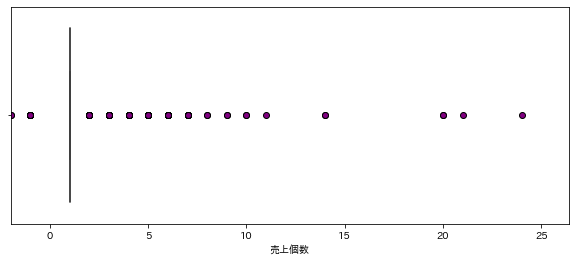

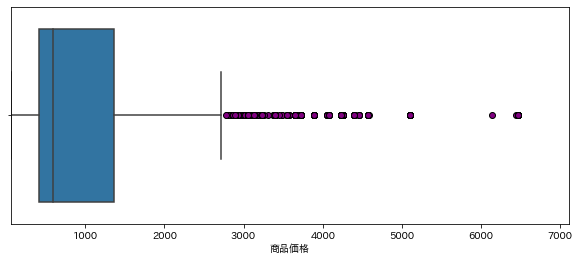

In [18]:
plt.figure(figsize=(10,4))
plt.xlim(sales.売上個数.min(), sales.売上個数.max()*1.1)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales.売上個数, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(sales.商品価格.min(), sales.商品価格.max()*1.1)
sns.boxplot(x=sales.商品価格, flierprops=flierprops)

In [19]:
# sales["売上個数"].clip(-4,100,inplace=True)
# sales["商品価格"].clip(0,70000,inplace=True)

# Create Dataset

### テーブル変換

In [20]:
def crate_monthly_table (df_sales):
  gp_month = df_sales.groupby(['月ブロック', '商品ID', '店舗ID']).agg({'売上個数': np.sum}).reset_index()
  yyyymm =  np.sort(df_sales.月ブロック.unique())
  all_combination = []
  columns = ['月ブロック', '商品ID', '店舗ID']

  #商品ID×店舗IDの直積
  for i in yyyymm:
    all_combination.append(list(product([i], df_sales.商品ID.unique(), df_sales.店舗ID.unique())))
  
  all_combination = pd.DataFrame(np.vstack(np.array(all_combination)), columns=columns)
  all_combination.sort_values(columns, inplace=True)

  # all_combinationにsalesテーブルを統合
  all_train = pd.merge(all_combination, gp_month, on=['月ブロック', '商品ID', '店舗ID'], how='left')
  # all_train['売上個数'] = all_train['売上個数'].fillna(0)

  return all_train

In [21]:
train = crate_monthly_table(sales)

In [23]:
train.describe(percentiles=[0.9,0.99,0.999,0.9999])

,月ブロック,商品ID,店舗ID,売上個数
count,67320.00,67320.00,67320.00,25407.00
mean,10.50,1868329.94,8.50,1.99
std,6.34,684659.75,5.19,2.36
min,0.00,1000001.00,0.00,-1.00
50%,10.50,1700013.50,8.50,1.00
90%,19.00,2800009.90,16.00,4.00
99%,21.00,3400003.00,17.00,10.00
99.9%,21.00,3500001.00,17.00,30.00
99.99%,21.00,3500001.00,17.00,64.46
max,21.00,3500001.00,17.00,88.00


In [24]:
train.isnull().sum()

月ブロック        0
商品ID         0
店舗ID         0
売上個数     41913
dtype: int64

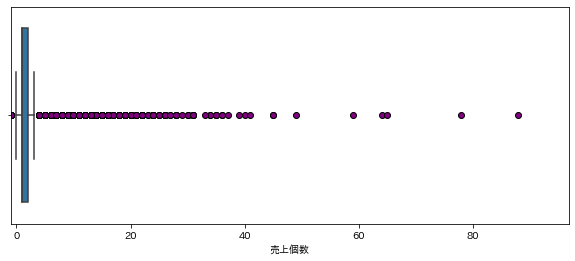

In [25]:
plt.figure(figsize=(10,4))
plt.xlim(train.売上個数.min(), train.売上個数.max()*1.1)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.売上個数, flierprops=flierprops)

In [26]:
train.shape

(67320, 4)

### train/testのデータ結合

In [37]:
def merge_train_test (df_train,df_test):
  df_test['月ブロック'] = 23
  dataset = pd.concat([df_train, df_test])

  return dataset

In [38]:
dataset = merge_train_test (train,test)
dataset.head()

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.00
1,0,1000001,1,2.00
2,0,1000001,2,1.00
3,0,1000001,3,2.00
4,0,1000001,4,0.00


# Feature Engneering

### 商品カテゴリ・時間情報の結合

In [39]:
def merge_category_columns(dataset,cats,cat_names,gp_time): 
  dataset = pd.merge(dataset, cats, on='商品ID', how='left')
  dataset = pd.merge(dataset, cat_names, on='商品カテゴリID', how='left')
  dataset = pd.merge(dataset, gp_time, on='月ブロック', how='left')

  return dataset

In [40]:
dataset = merge_category_columns(dataset,cats,cat_names,gp_time)
dataset.head()

,月ブロック,商品ID,店舗ID,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期
0,0,1000001,0,6.00,100,映画,DVD,2018,1,1
1,0,1000001,1,2.00,100,映画,DVD,2018,1,1
2,0,1000001,2,1.00,100,映画,DVD,2018,1,1
3,0,1000001,3,2.00,100,映画,DVD,2018,1,1
4,0,1000001,4,0.00,100,映画,DVD,2018,1,1


### 集約テーブル作成

In [41]:
#売上個数がマイナス＝返品と捉え、商品ID毎の返品数のテーブルを作成
returns = pd.DataFrame(sales[sales.売上個数 < 0].商品カテゴリID.value_counts()).reset_index()
returns.columns = ["商品カテゴリID","返品回数"]
returns

,商品カテゴリID,返品回数
0,120,21
1,260,9
2,280,6
3,100,5
4,210,5
5,240,4
6,110,4
7,340,4
8,320,3
9,230,3


In [42]:
#売上レコードが始めて現れた月　売上レコードなしの組み合わせは-1
sales_start_month = sales.groupby(["店舗ID","商品ID"])["月ブロック"].agg(販売開始月ブロック = "min").unstack(fill_value=-1).stack()
sales_start_month = pd.DataFrame(sales_start_month).reset_index()
sales_start_month.head()

,店舗ID,商品ID,販売開始月ブロック
0,0,1000001,0
1,0,1000002,0
2,0,1000003,1
3,0,1000004,0
4,0,1000005,0


In [43]:
#売上レコードが始めて現れた月　商品毎
sales_start_month_p = sales.groupby(["商品ID"])["月ブロック"].agg(販売開始月ブロック_pid = "min").reset_index()
sales_start_month_p.head()

,商品ID,販売開始月ブロック_pid
0,1000001,0
1,1000002,0
2,1000003,0
3,1000004,0
4,1000005,0


In [44]:
#商品ID毎に定価（価格の最大値、セール価格（min)、平均と中央を算出
#pid = product ID
agg_productID_price = sales.groupby(['商品ID'])["商品価格"].agg(定価_pid="max",セール価格_pid="min",平均価格_pid="mean",中央値価格_pid="median").reset_index()
price_bin = pd.DataFrame(pd.cut(agg_productID_price.定価_pid, [0, 300,500,750,1000,2000,3000,10000,30000,100000],labels=False))
price_bin.columns = ["価格帯"]
agg_productID_price = pd.concat([agg_productID_price,price_bin],axis=1)
agg_productID_price.head()

,商品ID,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯
0,1000001,420,120,367.81,420,1
1,1000002,250,100,236.97,250,0
2,1000003,250,120,228.66,250,0
3,1000004,250,120,224.03,250,0
4,1000005,250,90,245.25,250,0


In [45]:
#商品カテゴリID毎に定価（価格の最大値、セール価格（min)、平均と中央を算出
#cid = categoryID
agg_catID_price = sales.groupby(['商品カテゴリID'])["商品価格"].agg(最大価格_cid="max",最小価格_cid="min",平均価格_cid="mean",中央値価格_cid="median").reset_index()
agg_catID_price.head()

,商品カテゴリID,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid
0,100,680,90,348.36,250
1,110,590,60,191.16,170
2,120,3650,120,463.38,510
3,130,4250,760,1633.78,1530
4,140,1360,80,656.83,630


In [46]:
#商品大カテゴリID毎に定価（価格の最大値、セール価格（min)、平均と中央を算出
# lc = Large Category
agg_LargeCat_price = sales.groupby(['商品大カテゴリ'])["商品価格"].agg(最大価格_lc="max",最小価格_lc="min",平均価格_lc="mean",中央値価格_lc="median").reset_index()
agg_LargeCat_price.head()

,商品大カテゴリ,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc
0,PCゲーム,590,60,191.16,170
1,PCソフト,2870,1240,2423.83,2020
2,ギフト,5100,100,1465.86,1190
3,ゲーム,4250,760,1751.43,1700
4,ゲーム周辺機器,4570,330,1409.42,1190


In [47]:
dataset = pd.merge(dataset, returns, on='商品カテゴリID', how='left')
dataset = pd.merge(dataset, sales_start_month, on=["店舗ID","商品ID"], how='left')
dataset = pd.merge(dataset, sales_start_month_p, on='商品ID', how='left')
dataset = pd.merge(dataset, agg_productID_price, on='商品ID', how='left')
dataset = pd.merge(dataset, agg_catID_price, on='商品カテゴリID', how='left')
dataset = pd.merge(dataset, agg_LargeCat_price, on='商品大カテゴリ', how='left')

In [48]:
dataset.head()

,月ブロック,商品ID,店舗ID,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc
0,0,1000001,0,6.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420
1,0,1000001,1,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420
2,0,1000001,2,1.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420
3,0,1000001,3,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420
4,0,1000001,4,0.00,100,映画,DVD,2018,1,1,5.00,1,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420


### 販売実績　0 or 販売実績 null

In [49]:
dataset["未販売"] = (dataset["月ブロック"] <  dataset["販売開始月ブロック_pid"]).astype(int)
dataset.head()

,月ブロック,商品ID,店舗ID,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc,未販売
0,0,1000001,0,6.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
1,0,1000001,1,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
2,0,1000001,2,1.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
3,0,1000001,3,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
4,0,1000001,4,0.00,100,映画,DVD,2018,1,1,5.00,1,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0


In [50]:
dataset.未販売.value_counts()

0    60462
1     9918
Name: 未販売, dtype: int64

In [51]:
dataset  = dataset[dataset.未販売 == 0]

In [52]:
dataset["売上個数"].fillna(0,inplace=True)

In [53]:
dataset.shape

(60462, 27)

In [54]:
dataset.isnull().sum()

月ブロック               0
商品ID                0
店舗ID                0
売上個数                0
商品カテゴリID            0
商品大カテゴリ             0
商品小カテゴリ             0
年                   0
月                   0
四半期                 0
返品回数             3690
販売開始月ブロック           0
販売開始月ブロック_pid       0
定価_pid              0
セール価格_pid           0
平均価格_pid            0
中央値価格_pid           0
価格帯                 0
最大価格_cid            0
最小価格_cid            0
平均価格_cid            0
中央値価格_cid           0
最大価格_lc             0
最小価格_lc             0
平均価格_lc             0
中央値価格_lc            0
未販売                 0
dtype: int64

### 月毎の日数を追加、特定キーワードを含むカテゴリ列か判定する列を追加

In [55]:
dataset.head()

,月ブロック,商品ID,店舗ID,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc,未販売
0,0,1000001,0,6.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
1,0,1000001,1,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
2,0,1000001,2,1.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
3,0,1000001,3,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
4,0,1000001,4,0.00,100,映画,DVD,2018,1,1,5.00,1,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0


In [56]:
days_of_month = pd.DataFrame({'月': range(1,13),'日数': [31,28,31,30,31,30,31,31,30,31,30,31]})
dataset = pd.merge(dataset, days_of_month, on='月', how='left')

In [57]:
dataset["販売開始経過月ブロック_pid"] = (dataset["月ブロック"] - dataset["販売開始月ブロック_pid"]).astype("int8")
dataset["販売開始経過月ブロック"] = (dataset["月ブロック"] - dataset["販売開始月ブロック"]).astype("int8")

In [58]:
col = "商品小カテゴリ"
new_col = "ゲーム"
dataset[new_col] = dataset[col].str.contains(new_col).astype(int)

new_col = "記念品"
dataset[new_col] = dataset[col].str.contains(new_col).astype(int)

In [59]:
dataset["割引率"] = dataset["セール価格_pid"]/dataset["定価_pid"]

In [60]:
dataset["返品回数"].fillna(0,inplace=True)

In [61]:
dataset.head()

,月ブロック,商品ID,店舗ID,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc,未販売,日数,販売開始経過月ブロック_pid,販売開始経過月ブロック,ゲーム,記念品,割引率
0,0,1000001,0,6.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29
1,0,1000001,1,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29
2,0,1000001,2,1.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29
3,0,1000001,3,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29
4,0,1000001,4,0.00,100,映画,DVD,2018,1,1,5.00,1,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,-1,0,0,0.29


### 型変換

In [62]:
cols_int8 = ["月ブロック","店舗ID","年","月","四半期","返品回数","販売開始月ブロック","販売開始月ブロック_pid","価格帯","未販売","日数","ゲーム","記念品"]
dataset[cols_int8] = dataset[cols_int8].astype("int8")

In [63]:
cols_int32 = ["定価_pid","セール価格_pid","中央値価格_pid","最大価格_cid","最小価格_cid","中央値価格_cid","最大価格_lc","最小価格_lc","中央値価格_lc"]
dataset[cols_int32] = dataset[cols_int32].astype("int32")

In [64]:
dataset.dtypes

月ブロック                 int8
商品ID                 int64
店舗ID                  int8
売上個数               float64
商品カテゴリID             int64
商品大カテゴリ             object
商品小カテゴリ             object
年                     int8
月                     int8
四半期                   int8
返品回数                  int8
販売開始月ブロック             int8
販売開始月ブロック_pid         int8
定価_pid               int32
セール価格_pid            int32
平均価格_pid           float64
中央値価格_pid            int32
価格帯                   int8
最大価格_cid             int32
最小価格_cid             int32
平均価格_cid           float64
中央値価格_cid            int32
最大価格_lc              int32
最小価格_lc              int32
平均価格_lc            float64
中央値価格_lc             int32
未販売                   int8
日数                    int8
販売開始経過月ブロック_pid       int8
販売開始経過月ブロック           int8
ゲーム                   int8
記念品                   int8
割引率                float64
dtype: object

### ラグ特徴量の作成

In [65]:
def create_lag_feature(df_sales,dataset,month,agg_name,agg_cols):
  gp_month_count = df_sales.groupby(agg_cols).agg({'売上個数': "count"}).reset_index()
  gp_month_sum = df_sales.groupby(agg_cols).agg({'売上個数': np.sum}).reset_index()
  gp_month_mean = df_sales.groupby(agg_cols).agg({'売上個数': np.mean}).reset_index()
  gp_month_max = df_sales.groupby(agg_cols).agg({'売上個数': np.max}).reset_index()

  gp_month_list = [gp_month_count,gp_month_sum,gp_month_mean,gp_month_max]
  gp_month_names = ["count","sum","mean","max"]


  for gp_month,gp_month_name in zip(gp_month_list,gp_month_names):
    # for i in range(2,month,3):
    for i in [2,3,4,12]:
      lag = gp_month.copy()   
      lag['月ブロック'] = lag['月ブロック'] + i

      change_col_name = str(i)+'m_('+agg_name+')売上数_'+gp_month_name
      lag = lag.rename(columns={'売上個数': change_col_name})

      dataset = pd.merge(dataset, lag, on= agg_cols, how='left', left_index=True)
      dataset[change_col_name].fillna(0,inplace=True)
  return dataset

In [67]:
month = 5
agg_names = ["個別","商品別","カテゴリID別","大カテゴリ別","価格帯別"]
agg_cols_list = [['月ブロック', '商品ID','店舗ID'],['月ブロック', '商品ID'],['月ブロック','商品カテゴリID'],['月ブロック', '商品大カテゴリ'],['月ブロック','価格帯']]

for agg_name,agg_cols in zip(agg_names,agg_cols_list):
  dataset = create_lag_feature(sales,dataset,month,agg_name,agg_cols)

### 移動統計量の作成

In [70]:
def create_rolling_feature(dataset,cols_target,col_name_prefix): 
  
  cols_3m = cols_target[:2]
  cols_4m = cols_target[:3]
  # cols_5m = cols_target[:4]
  # cols_6m = cols_target[:5]
  # cols_7m = cols_target[:6]
  # cols_8m = cols_target[:7]
  # cols_9m = cols_target[:8]
  # cols_10m = cols_target[:9]
  # cols_11m = cols_target[:10]
  cols_12m = cols_target

  # cols_list = [cols_3m,cols_4m,cols_5m,cols_6m,cols_7m,cols_8m,cols_9m,cols_10m,cols_11m,cols_12m]
  # cols_list = [cols_3m,cols_6m,cols_9m,cols_12m]
  cols_list = [cols_3m,cols_4m,cols_12m]

  # agg_num = [3,4,5,6,7,8,9,10,11,12]
  # agg_num = [3,6,9,12]
  agg_num = [3,4,12]
  

  for num,cols in zip(agg_num,cols_list): 
    col_name = '売上個数({})_agg{}m_sum'.format( col_name_prefix, num )
    dataset[col_name] = dataset[cols].sum(axis=1)

    col_name = '売上個数({})_agg{}m_max'.format( col_name_prefix, num )
    dataset[col_name] = dataset[cols].max(axis=1)

    col_name = '売上個数({})_agg{}m_mean'.format(col_name_prefix,  num )
    dataset[col_name] = dataset[cols].mean(axis=1)

  return dataset

In [71]:
cols = list(dataset.columns)

cols_combi = [col for col in cols if '(個別)売上数_sum' in col]
cols_product = [col for col in cols if '(商品別)売上数_sum' in col]
cols_catID = [col for col in cols if '(カテゴリID別)売上数_sum' in col]
cols_catL = [col for col in cols if '(大カテゴリ別)売上数_sum' in col]
cols_priceBin = [col for col in cols if '(価格帯別)売上数_sum' in col]

cols_target_list = [cols_combi,cols_product,cols_catID,cols_catL,cols_priceBin]
col_name_prefix_list = ["個別","商品別","カテゴリID別","大カテゴリ別","価格帯別"]

for cols_target ,col_name_prefix in zip(cols_target_list,col_name_prefix_list):
  dataset = create_rolling_feature(dataset , cols_target, col_name_prefix)
  

### translate data type

In [72]:
dataset.describe()

,月ブロック,商品ID,店舗ID,売上個数,商品カテゴリID,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc,未販売,日数,販売開始経過月ブロック_pid,販売開始経過月ブロック,ゲーム,記念品,割引率,2m_(個別)売上数_count,3m_(個別)売上数_count,4m_(個別)売上数_count,12m_(個別)売上数_count,2m_(個別)売上数_sum,3m_(個別)売上数_sum,4m_(個別)売上数_sum,12m_(個別)売上数_sum,2m_(個別)売上数_mean,3m_(個別)売上数_mean,4m_(個別)売上数_mean,12m_(個別)売上数_mean,2m_(個別)売上数_max,3m_(個別)売上数_max,4m_(個別)売上数_max,12m_(個別)売上数_max,2m_(商品別)売上数_count,3m_(商品別)売上数_count,4m_(商品別)売上数_count,12m_(商品別)売上数_count,2m_(商品別)売上数_sum,3m_(商品別)売上数_sum,4m_(商品別)売上数_sum,12m_(商品別)売上数_sum,2m_(商品別)売上数_mean,3m_(商品別)売上数_mean,4m_(商品別)売上数_mean,12m_(商品別)売上数_mean,2m_(商品別)売上数_max,3m_(商品別)売上数_max,4m_(商品別)売上数_max,12m_(商品別)売上数_max,2m_(カテゴリID別)売上数_count,3m_(カテゴリID別)売上数_count,4m_(カテゴリID別)売上数_count,12m_(カテゴリID別)売上数_count,2m_(カテゴリID別)売上数_sum,3m_(カテゴリID別)売上数_sum,4m_(カテゴリID別)売上数_sum,12m_(カテゴリID別)売上数_sum,2m_(カテゴリID別)売上数_mean,3m_(カテゴリID別)売上数_mean,4m_(カテゴリID別)売上数_mean,12m_(カテゴリID別)売上数_mean,2m_(カテゴリID別)売上数_max,3m_(カテゴリID別)売上数_max,4m_(カテゴリID別)売上数_max,12m_(カテゴリID別)売上数_max,2m_(大カテゴリ別)売上数_count,3m_(大カテゴリ別)売上数_count,4m_(大カテゴリ別)売上数_count,12m_(大カテゴリ別)売上数_count,2m_(大カテゴリ別)売上数_sum,3m_(大カテゴリ別)売上数_sum,4m_(大カテゴリ別)売上数_sum,12m_(大カテゴリ別)売上数_sum,2m_(大カテゴリ別)売上数_mean,3m_(大カテゴリ別)売上数_mean,4m_(大カテゴリ別)売上数_mean,12m_(大カテゴリ別)売上数_mean,2m_(大カテゴリ別)売上数_max,3m_(大カテゴリ別)売上数_max,4m_(大カテゴリ別)売上数_max,12m_(大カテゴリ別)売上数_max,2m_(価格帯別)売上数_count,3m_(価格帯別)売上数_count,4m_(価格帯別)売上数_count,12m_(価格帯別)売上数_count,2m_(価格帯別)売上数_sum,3m_(価格帯別)売上数_sum,4m_(価格帯別)売上数_sum,12m_(価格帯別)売上数_sum,2m_(価格帯別)売上数_mean,3m_(価格帯別)売上数_mean,4m_(価格帯別)売上数_mean,12m_(価格帯別)売上数_mean,2m_(価格帯別)売上数_max,3m_(価格帯別)売上数_max,4m_(価格帯別)売上数_max,12m_(価格帯別)売上数_max,売上個数(個別)_agg3m_sum,売上個数(個別)_agg3m_max,売上個数(個別)_agg3m_mean,売上個数(個別)_agg4m_sum,売上個数(個別)_agg4m_max,売上個数(個別)_agg4m_mean,売上個数(個別)_agg12m_sum,売上個数(個別)_agg12m_max,売上個数(個別)_agg12m_mean,売上個数(商品別)_agg3m_sum,売上個数(商品別)_agg3m_max,売上個数(商品別)_agg3m_mean,売上個数(商品別)_agg4m_sum,売上個数(商品別)_agg4m_max,売上個数(商品別)_agg4m_mean,売上個数(商品別)_agg12m_sum,売上個数(商品別)_agg12m_max,売上個数(商品別)_agg12m_mean,売上個数(カテゴリID別)_agg3m_sum,売上個数(カテゴリID別)_agg3m_max,売上個数(カテゴリID別)_agg3m_mean,売上個数(カテゴリID別)_agg4m_sum,売上個数(カテゴリID別)_agg4m_max,売上個数(カテゴリID別)_agg4m_mean,売上個数(カテゴリID別)_agg12m_sum,売上個数(カテゴリID別)_agg12m_max,売上個数(カテゴリID別)_agg12m_mean,売上個数(大カテゴリ別)_agg3m_sum,売上個数(大カテゴリ別)_agg3m_max,売上個数(大カテゴリ別)_agg3m_mean,売上個数(大カテゴリ別)_agg4m_sum,売上個数(大カテゴリ別)_agg4m_max,売上個数(大カテゴリ別)_agg4m_mean,売上個数(大カテゴリ別)_agg12m_sum,売上個数(大カテゴリ別)_agg12m_max,売上個数(大カテゴリ別)_agg12m_mean,売上個数(価格帯別)_agg3m_sum,売上個数(価格帯別)_agg3m_max,売上個数(価格帯別)_agg3m_mean,売上個数(価格帯別)_agg4m_sum,売上個数(価格帯別)_agg4m_max,売上個数(価格帯別)_agg4m_mean,売上個数(価格帯別)_agg12m_sum,売上個数(価格帯別)_agg12m_max,売上個数(価格帯別)_agg12m_mean
count,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00

- 商品ID 
- 店舗ID 
- 商品カテゴリID
- 商品大カテゴリ 
- 商品小カテゴリ 

In [73]:
col = "商品ID"

df = dataset.copy()
df["売上金額"] = df["売上個数"] * df["平均価格_pid"]
df_agg = df.groupby(col).agg({"売上金額":np.sum}).reset_index()
df_agg.rename(columns={'売上金額': "変換"+col},inplace=True)
df_agg.nunique()

dataset = pd.merge(dataset, df_agg, on=col, how='left')
dataset.drop(col,axis=1,inplace=True)

In [74]:
col = "店舗ID"

df_agg = dataset.groupby(col).agg({"売上個数":np.sum}).reset_index()
df_agg.rename(columns={'売上個数': "変換"+col},inplace=True)
df_agg.nunique()

dataset = pd.merge(dataset, df_agg, on=col, how='left')
dataset.drop(col,axis=1,inplace=True)
dataset.head()

,月ブロック,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc,未販売,日数,販売開始経過月ブロック_pid,販売開始経過月ブロック,ゲーム,記念品,割引率,2m_(個別)売上数_count,3m_(個別)売上数_count,4m_(個別)売上数_count,12m_(個別)売上数_count,2m_(個別)売上数_sum,3m_(個別)売上数_sum,4m_(個別)売上数_sum,12m_(個別)売上数_sum,2m_(個別)売上数_mean,3m_(個別)売上数_mean,4m_(個別)売上数_mean,12m_(個別)売上数_mean,2m_(個別)売上数_max,3m_(個別)売上数_max,4m_(個別)売上数_max,12m_(個別)売上数_max,2m_(商品別)売上数_count,3m_(商品別)売上数_count,4m_(商品別)売上数_count,12m_(商品別)売上数_count,2m_(商品別)売上数_sum,3m_(商品別)売上数_sum,4m_(商品別)売上数_sum,12m_(商品別)売上数_sum,2m_(商品別)売上数_mean,3m_(商品別)売上数_mean,4m_(商品別)売上数_mean,12m_(商品別)売上数_mean,2m_(商品別)売上数_max,3m_(商品別)売上数_max,4m_(商品別)売上数_max,12m_(商品別)売上数_max,2m_(カテゴリID別)売上数_count,3m_(カテゴリID別)売上数_count,4m_(カテゴリID別)売上数_count,12m_(カテゴリID別)売上数_count,2m_(カテゴリID別)売上数_sum,3m_(カテゴリID別)売上数_sum,4m_(カテゴリID別)売上数_sum,12m_(カテゴリID別)売上数_sum,2m_(カテゴリID別)売上数_mean,3m_(カテゴリID別)売上数_mean,4m_(カテゴリID別)売上数_mean,12m_(カテゴリID別)売上数_mean,2m_(カテゴリID別)売上数_max,3m_(カテゴリID別)売上数_max,4m_(カテゴリID別)売上数_max,12m_(カテゴリID別)売上数_max,2m_(大カテゴリ別)売上数_count,3m_(大カテゴリ別)売上数_count,4m_(大カテゴリ別)売上数_count,12m_(大カテゴリ別)売上数_count,2m_(大カテゴリ別)売上数_sum,3m_(大カテゴリ別)売上数_sum,4m_(大カテゴリ別)売上数_sum,12m_(大カテゴリ別)売上数_sum,2m_(大カテゴリ別)売上数_mean,3m_(大カテゴリ別)売上数_mean,4m_(大カテゴリ別)売上数_mean,12m_(大カテゴリ別)売上数_mean,2m_(大カテゴリ別)売上数_max,3m_(大カテゴリ別)売上数_max,4m_(大カテゴリ別)売上数_max,12m_(大カテゴリ別)売上数_max,2m_(価格帯別)売上数_count,3m_(価格帯別)売上数_count,4m_(価格帯別)売上数_count,12m_(価格帯別)売上数_count,2m_(価格帯別)売上数_sum,3m_(価格帯別)売上数_sum,4m_(価格帯別)売上数_sum,12m_(価格帯別)売上数_sum,2m_(価格帯別)売上数_mean,3m_(価格帯別)売上数_mean,4m_(価格帯別)売上数_mean,12m_(価格帯別)売上数_mean,2m_(価格帯別)売上数_max,3m_(価格帯別)売上数_max,4m_(価格帯別)売上数_max,12m_(価格帯別)売上数_max,売上個数(個別)_agg3m_sum,売上個数(個別)_agg3m_max,売上個数(個別)_agg3m_mean,売上個数(個別)_agg4m_sum,売上個数(個別)_agg4m_max,売上個数(個別)_agg4m_mean,売上個数(個別)_agg12m_sum,売上個数(個別)_agg12m_max,売上個数(個別)_agg12m_mean,売上個数(商品別)_agg3m_sum,売上個数(商品別)_agg3m_max,売上個数(商品別)_agg3m_mean,売上個数(商品別)_agg4m_sum,売上個数(商品別)_agg4m_max,売上個数(商品別)_agg4m_mean,売上個数(商品別)_agg12m_sum,売上個数(商品別)_agg12m_max,売上個数(商品別)_agg12m_mean,売上個数(カテゴリID別)_agg3m_sum,売上個数(カテゴリID別)_agg3m_max,売上個数(カテゴリID別)_agg3m_mean,売上個数(カテゴリID別)_agg4m_sum,売上個数(カテゴリID別)_agg4m_max,売上個数(カテゴリID別)_agg4m_mean,売上個数(カテゴリID別)_agg12m_sum,売上個数(カテゴリID別)_agg12m_max,売上個数(カテゴリID別)_agg12m_mean,売上個数(大カテゴリ別)_agg3m_sum,売上個数(大カテゴリ別)_agg3m_max,売上個数(大カテゴリ別)_agg3m_mean,売上個数(大カテゴリ別)_agg4m_sum,売上個数(大カテゴリ別)_agg4m_max,売上個数(大カテゴリ別)_agg4m_mean,売上個数(大カテゴリ別)_agg12m_sum,売上個数(大カテゴリ別)_agg12m_max,売上個数(大カテゴリ別)_agg12m_mean,売上個数(価格帯別)_agg3m_sum,売上個数(価格帯別)_agg3m_max,売上個数(価格帯別)_agg3m_mean,売上個数(価格帯別)_agg4m_sum,売上個数(価格帯別)_agg4m_max,売上個数(価格帯別)_agg4m_mean,売上個数(価格帯別)_agg12m_sum,売上個数(価格帯別)_agg12m_max,売上個数(価格帯別)_agg12m_mean,変換商品ID,変換店舗ID
0,0,6.00,100,映画,DVD,-30,1,1,5,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,228412.22,4287.00
1,0,2.00,100,映画,DVD,-30,1,1,5,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

In [75]:
col = "商品カテゴリID"

df_agg = dataset.groupby(col).agg({"売上個数":np.sum}).reset_index()
df_agg.rename(columns={'売上個数': "変換"+col},inplace=True)
df_agg.nunique()

dataset = pd.merge(dataset, df_agg, on=col, how='left')
dataset.drop(col,axis=1,inplace=True)
dataset.head()

,月ブロック,売上個数,商品大カテゴリ,商品小カテゴリ,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc,未販売,日数,販売開始経過月ブロック_pid,販売開始経過月ブロック,ゲーム,記念品,割引率,2m_(個別)売上数_count,3m_(個別)売上数_count,4m_(個別)売上数_count,12m_(個別)売上数_count,2m_(個別)売上数_sum,3m_(個別)売上数_sum,4m_(個別)売上数_sum,12m_(個別)売上数_sum,2m_(個別)売上数_mean,3m_(個別)売上数_mean,4m_(個別)売上数_mean,12m_(個別)売上数_mean,2m_(個別)売上数_max,3m_(個別)売上数_max,4m_(個別)売上数_max,12m_(個別)売上数_max,2m_(商品別)売上数_count,3m_(商品別)売上数_count,4m_(商品別)売上数_count,12m_(商品別)売上数_count,2m_(商品別)売上数_sum,3m_(商品別)売上数_sum,4m_(商品別)売上数_sum,12m_(商品別)売上数_sum,2m_(商品別)売上数_mean,3m_(商品別)売上数_mean,4m_(商品別)売上数_mean,12m_(商品別)売上数_mean,2m_(商品別)売上数_max,3m_(商品別)売上数_max,4m_(商品別)売上数_max,12m_(商品別)売上数_max,2m_(カテゴリID別)売上数_count,3m_(カテゴリID別)売上数_count,4m_(カテゴリID別)売上数_count,12m_(カテゴリID別)売上数_count,2m_(カテゴリID別)売上数_sum,3m_(カテゴリID別)売上数_sum,4m_(カテゴリID別)売上数_sum,12m_(カテゴリID別)売上数_sum,2m_(カテゴリID別)売上数_mean,3m_(カテゴリID別)売上数_mean,4m_(カテゴリID別)売上数_mean,12m_(カテゴリID別)売上数_mean,2m_(カテゴリID別)売上数_max,3m_(カテゴリID別)売上数_max,4m_(カテゴリID別)売上数_max,12m_(カテゴリID別)売上数_max,2m_(大カテゴリ別)売上数_count,3m_(大カテゴリ別)売上数_count,4m_(大カテゴリ別)売上数_count,12m_(大カテゴリ別)売上数_count,2m_(大カテゴリ別)売上数_sum,3m_(大カテゴリ別)売上数_sum,4m_(大カテゴリ別)売上数_sum,12m_(大カテゴリ別)売上数_sum,2m_(大カテゴリ別)売上数_mean,3m_(大カテゴリ別)売上数_mean,4m_(大カテゴリ別)売上数_mean,12m_(大カテゴリ別)売上数_mean,2m_(大カテゴリ別)売上数_max,3m_(大カテゴリ別)売上数_max,4m_(大カテゴリ別)売上数_max,12m_(大カテゴリ別)売上数_max,2m_(価格帯別)売上数_count,3m_(価格帯別)売上数_count,4m_(価格帯別)売上数_count,12m_(価格帯別)売上数_count,2m_(価格帯別)売上数_sum,3m_(価格帯別)売上数_sum,4m_(価格帯別)売上数_sum,12m_(価格帯別)売上数_sum,2m_(価格帯別)売上数_mean,3m_(価格帯別)売上数_mean,4m_(価格帯別)売上数_mean,12m_(価格帯別)売上数_mean,2m_(価格帯別)売上数_max,3m_(価格帯別)売上数_max,4m_(価格帯別)売上数_max,12m_(価格帯別)売上数_max,売上個数(個別)_agg3m_sum,売上個数(個別)_agg3m_max,売上個数(個別)_agg3m_mean,売上個数(個別)_agg4m_sum,売上個数(個別)_agg4m_max,売上個数(個別)_agg4m_mean,売上個数(個別)_agg12m_sum,売上個数(個別)_agg12m_max,売上個数(個別)_agg12m_mean,売上個数(商品別)_agg3m_sum,売上個数(商品別)_agg3m_max,売上個数(商品別)_agg3m_mean,売上個数(商品別)_agg4m_sum,売上個数(商品別)_agg4m_max,売上個数(商品別)_agg4m_mean,売上個数(商品別)_agg12m_sum,売上個数(商品別)_agg12m_max,売上個数(商品別)_agg12m_mean,売上個数(カテゴリID別)_agg3m_sum,売上個数(カテゴリID別)_agg3m_max,売上個数(カテゴリID別)_agg3m_mean,売上個数(カテゴリID別)_agg4m_sum,売上個数(カテゴリID別)_agg4m_max,売上個数(カテゴリID別)_agg4m_mean,売上個数(カテゴリID別)_agg12m_sum,売上個数(カテゴリID別)_agg12m_max,売上個数(カテゴリID別)_agg12m_mean,売上個数(大カテゴリ別)_agg3m_sum,売上個数(大カテゴリ別)_agg3m_max,売上個数(大カテゴリ別)_agg3m_mean,売上個数(大カテゴリ別)_agg4m_sum,売上個数(大カテゴリ別)_agg4m_max,売上個数(大カテゴリ別)_agg4m_mean,売上個数(大カテゴリ別)_agg12m_sum,売上個数(大カテゴリ別)_agg12m_max,売上個数(大カテゴリ別)_agg12m_mean,売上個数(価格帯別)_agg3m_sum,売上個数(価格帯別)_agg3m_max,売上個数(価格帯別)_agg3m_mean,売上個数(価格帯別)_agg4m_sum,売上個数(価格帯別)_agg4m_max,売上個数(価格帯別)_agg4m_mean,売上個数(価格帯別)_agg12m_sum,売上個数(価格帯別)_agg12m_max,売上個数(価格帯別)_agg12m_mean,変換商品ID,変換店舗ID,変換商品カテゴリID
0,0,6.00,映画,DVD,-30,1,1,5,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,228412.22,4287.00,4743.00
1,0,2.00,映画,DVD,-30,1,1,5,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

In [76]:
col = "商品大カテゴリ"

df_agg = dataset.groupby(col).agg({"売上個数":np.sum}).reset_index()
df_agg.rename(columns={'売上個数': "変換"+col},inplace=True)
df_agg.nunique()

dataset = pd.merge(dataset, df_agg, on=col, how='left')
dataset.drop(col,axis=1,inplace=True)
dataset.head()

,月ブロック,売上個数,商品小カテゴリ,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc,未販売,日数,販売開始経過月ブロック_pid,販売開始経過月ブロック,ゲーム,記念品,割引率,2m_(個別)売上数_count,3m_(個別)売上数_count,4m_(個別)売上数_count,12m_(個別)売上数_count,2m_(個別)売上数_sum,3m_(個別)売上数_sum,4m_(個別)売上数_sum,12m_(個別)売上数_sum,2m_(個別)売上数_mean,3m_(個別)売上数_mean,4m_(個別)売上数_mean,12m_(個別)売上数_mean,2m_(個別)売上数_max,3m_(個別)売上数_max,4m_(個別)売上数_max,12m_(個別)売上数_max,2m_(商品別)売上数_count,3m_(商品別)売上数_count,4m_(商品別)売上数_count,12m_(商品別)売上数_count,2m_(商品別)売上数_sum,3m_(商品別)売上数_sum,4m_(商品別)売上数_sum,12m_(商品別)売上数_sum,2m_(商品別)売上数_mean,3m_(商品別)売上数_mean,4m_(商品別)売上数_mean,12m_(商品別)売上数_mean,2m_(商品別)売上数_max,3m_(商品別)売上数_max,4m_(商品別)売上数_max,12m_(商品別)売上数_max,2m_(カテゴリID別)売上数_count,3m_(カテゴリID別)売上数_count,4m_(カテゴリID別)売上数_count,12m_(カテゴリID別)売上数_count,2m_(カテゴリID別)売上数_sum,3m_(カテゴリID別)売上数_sum,4m_(カテゴリID別)売上数_sum,12m_(カテゴリID別)売上数_sum,2m_(カテゴリID別)売上数_mean,3m_(カテゴリID別)売上数_mean,4m_(カテゴリID別)売上数_mean,12m_(カテゴリID別)売上数_mean,2m_(カテゴリID別)売上数_max,3m_(カテゴリID別)売上数_max,4m_(カテゴリID別)売上数_max,12m_(カテゴリID別)売上数_max,2m_(大カテゴリ別)売上数_count,3m_(大カテゴリ別)売上数_count,4m_(大カテゴリ別)売上数_count,12m_(大カテゴリ別)売上数_count,2m_(大カテゴリ別)売上数_sum,3m_(大カテゴリ別)売上数_sum,4m_(大カテゴリ別)売上数_sum,12m_(大カテゴリ別)売上数_sum,2m_(大カテゴリ別)売上数_mean,3m_(大カテゴリ別)売上数_mean,4m_(大カテゴリ別)売上数_mean,12m_(大カテゴリ別)売上数_mean,2m_(大カテゴリ別)売上数_max,3m_(大カテゴリ別)売上数_max,4m_(大カテゴリ別)売上数_max,12m_(大カテゴリ別)売上数_max,2m_(価格帯別)売上数_count,3m_(価格帯別)売上数_count,4m_(価格帯別)売上数_count,12m_(価格帯別)売上数_count,2m_(価格帯別)売上数_sum,3m_(価格帯別)売上数_sum,4m_(価格帯別)売上数_sum,12m_(価格帯別)売上数_sum,2m_(価格帯別)売上数_mean,3m_(価格帯別)売上数_mean,4m_(価格帯別)売上数_mean,12m_(価格帯別)売上数_mean,2m_(価格帯別)売上数_max,3m_(価格帯別)売上数_max,4m_(価格帯別)売上数_max,12m_(価格帯別)売上数_max,売上個数(個別)_agg3m_sum,売上個数(個別)_agg3m_max,売上個数(個別)_agg3m_mean,売上個数(個別)_agg4m_sum,売上個数(個別)_agg4m_max,売上個数(個別)_agg4m_mean,売上個数(個別)_agg12m_sum,売上個数(個別)_agg12m_max,売上個数(個別)_agg12m_mean,売上個数(商品別)_agg3m_sum,売上個数(商品別)_agg3m_max,売上個数(商品別)_agg3m_mean,売上個数(商品別)_agg4m_sum,売上個数(商品別)_agg4m_max,売上個数(商品別)_agg4m_mean,売上個数(商品別)_agg12m_sum,売上個数(商品別)_agg12m_max,売上個数(商品別)_agg12m_mean,売上個数(カテゴリID別)_agg3m_sum,売上個数(カテゴリID別)_agg3m_max,売上個数(カテゴリID別)_agg3m_mean,売上個数(カテゴリID別)_agg4m_sum,売上個数(カテゴリID別)_agg4m_max,売上個数(カテゴリID別)_agg4m_mean,売上個数(カテゴリID別)_agg12m_sum,売上個数(カテゴリID別)_agg12m_max,売上個数(カテゴリID別)_agg12m_mean,売上個数(大カテゴリ別)_agg3m_sum,売上個数(大カテゴリ別)_agg3m_max,売上個数(大カテゴリ別)_agg3m_mean,売上個数(大カテゴリ別)_agg4m_sum,売上個数(大カテゴリ別)_agg4m_max,売上個数(大カテゴリ別)_agg4m_mean,売上個数(大カテゴリ別)_agg12m_sum,売上個数(大カテゴリ別)_agg12m_max,売上個数(大カテゴリ別)_agg12m_mean,売上個数(価格帯別)_agg3m_sum,売上個数(価格帯別)_agg3m_max,売上個数(価格帯別)_agg3m_mean,売上個数(価格帯別)_agg4m_sum,売上個数(価格帯別)_agg4m_max,売上個数(価格帯別)_agg4m_mean,売上個数(価格帯別)_agg12m_sum,売上個数(価格帯別)_agg12m_max,売上個数(価格帯別)_agg12m_mean,変換商品ID,変換店舗ID,変換商品カテゴリID,変換商品大カテゴリ
0,0,6.00,DVD,-30,1,1,5,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,228412.22,4287.00,4743.00,8082.00
1,0,2.00,DVD,-30,1,1,5,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

In [77]:
col = "商品小カテゴリ"

df_agg = dataset.groupby(col).agg({"売上個数":np.sum}).reset_index()
df_agg.rename(columns={'売上個数': "変換"+col},inplace=True)
df_agg.nunique()

dataset = pd.merge(dataset, df_agg, on=col, how='left')
dataset.drop(col,axis=1,inplace=True)
dataset.head()

,月ブロック,売上個数,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc,未販売,日数,販売開始経過月ブロック_pid,販売開始経過月ブロック,ゲーム,記念品,割引率,2m_(個別)売上数_count,3m_(個別)売上数_count,4m_(個別)売上数_count,12m_(個別)売上数_count,2m_(個別)売上数_sum,3m_(個別)売上数_sum,4m_(個別)売上数_sum,12m_(個別)売上数_sum,2m_(個別)売上数_mean,3m_(個別)売上数_mean,4m_(個別)売上数_mean,12m_(個別)売上数_mean,2m_(個別)売上数_max,3m_(個別)売上数_max,4m_(個別)売上数_max,12m_(個別)売上数_max,2m_(商品別)売上数_count,3m_(商品別)売上数_count,4m_(商品別)売上数_count,12m_(商品別)売上数_count,2m_(商品別)売上数_sum,3m_(商品別)売上数_sum,4m_(商品別)売上数_sum,12m_(商品別)売上数_sum,2m_(商品別)売上数_mean,3m_(商品別)売上数_mean,4m_(商品別)売上数_mean,12m_(商品別)売上数_mean,2m_(商品別)売上数_max,3m_(商品別)売上数_max,4m_(商品別)売上数_max,12m_(商品別)売上数_max,2m_(カテゴリID別)売上数_count,3m_(カテゴリID別)売上数_count,4m_(カテゴリID別)売上数_count,12m_(カテゴリID別)売上数_count,2m_(カテゴリID別)売上数_sum,3m_(カテゴリID別)売上数_sum,4m_(カテゴリID別)売上数_sum,12m_(カテゴリID別)売上数_sum,2m_(カテゴリID別)売上数_mean,3m_(カテゴリID別)売上数_mean,4m_(カテゴリID別)売上数_mean,12m_(カテゴリID別)売上数_mean,2m_(カテゴリID別)売上数_max,3m_(カテゴリID別)売上数_max,4m_(カテゴリID別)売上数_max,12m_(カテゴリID別)売上数_max,2m_(大カテゴリ別)売上数_count,3m_(大カテゴリ別)売上数_count,4m_(大カテゴリ別)売上数_count,12m_(大カテゴリ別)売上数_count,2m_(大カテゴリ別)売上数_sum,3m_(大カテゴリ別)売上数_sum,4m_(大カテゴリ別)売上数_sum,12m_(大カテゴリ別)売上数_sum,2m_(大カテゴリ別)売上数_mean,3m_(大カテゴリ別)売上数_mean,4m_(大カテゴリ別)売上数_mean,12m_(大カテゴリ別)売上数_mean,2m_(大カテゴリ別)売上数_max,3m_(大カテゴリ別)売上数_max,4m_(大カテゴリ別)売上数_max,12m_(大カテゴリ別)売上数_max,2m_(価格帯別)売上数_count,3m_(価格帯別)売上数_count,4m_(価格帯別)売上数_count,12m_(価格帯別)売上数_count,2m_(価格帯別)売上数_sum,3m_(価格帯別)売上数_sum,4m_(価格帯別)売上数_sum,12m_(価格帯別)売上数_sum,2m_(価格帯別)売上数_mean,3m_(価格帯別)売上数_mean,4m_(価格帯別)売上数_mean,12m_(価格帯別)売上数_mean,2m_(価格帯別)売上数_max,3m_(価格帯別)売上数_max,4m_(価格帯別)売上数_max,12m_(価格帯別)売上数_max,売上個数(個別)_agg3m_sum,売上個数(個別)_agg3m_max,売上個数(個別)_agg3m_mean,売上個数(個別)_agg4m_sum,売上個数(個別)_agg4m_max,売上個数(個別)_agg4m_mean,売上個数(個別)_agg12m_sum,売上個数(個別)_agg12m_max,売上個数(個別)_agg12m_mean,売上個数(商品別)_agg3m_sum,売上個数(商品別)_agg3m_max,売上個数(商品別)_agg3m_mean,売上個数(商品別)_agg4m_sum,売上個数(商品別)_agg4m_max,売上個数(商品別)_agg4m_mean,売上個数(商品別)_agg12m_sum,売上個数(商品別)_agg12m_max,売上個数(商品別)_agg12m_mean,売上個数(カテゴリID別)_agg3m_sum,売上個数(カテゴリID別)_agg3m_max,売上個数(カテゴリID別)_agg3m_mean,売上個数(カテゴリID別)_agg4m_sum,売上個数(カテゴリID別)_agg4m_max,売上個数(カテゴリID別)_agg4m_mean,売上個数(カテゴリID別)_agg12m_sum,売上個数(カテゴリID別)_agg12m_max,売上個数(カテゴリID別)_agg12m_mean,売上個数(大カテゴリ別)_agg3m_sum,売上個数(大カテゴリ別)_agg3m_max,売上個数(大カテゴリ別)_agg3m_mean,売上個数(大カテゴリ別)_agg4m_sum,売上個数(大カテゴリ別)_agg4m_max,売上個数(大カテゴリ別)_agg4m_mean,売上個数(大カテゴリ別)_agg12m_sum,売上個数(大カテゴリ別)_agg12m_max,売上個数(大カテゴリ別)_agg12m_mean,売上個数(価格帯別)_agg3m_sum,売上個数(価格帯別)_agg3m_max,売上個数(価格帯別)_agg3m_mean,売上個数(価格帯別)_agg4m_sum,売上個数(価格帯別)_agg4m_max,売上個数(価格帯別)_agg4m_mean,売上個数(価格帯別)_agg12m_sum,売上個数(価格帯別)_agg12m_max,売上個数(価格帯別)_agg12m_mean,変換商品ID,変換店舗ID,変換商品カテゴリID,変換商品大カテゴリ,変換商品小カテゴリ
0,0,6.00,-30,1,1,5,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,228412.22,4287.00,4743.00,8082.00,4743.00
1,0,2.00,-30,1,1,5,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0,31,0,0,0,0,0.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [78]:
dataset.drop("未販売",axis=1,inplace=True)

# Modeling

### 検定あり

In [79]:
def train_test_split(dataset):
  # train_dataset = dataset[(dataset['月ブロック'] >= 6) &(dataset['月ブロック'] != 11)& (dataset['月ブロック'] < 22)]
  train_dataset = dataset[(dataset['月ブロック'] >= 12) &(dataset['月ブロック'] < 20)]
  valid_dataset = dataset[dataset['月ブロック'] == 21]
  test_dataset = dataset[dataset['月ブロック'] == 23]

  X_train = train_dataset.drop('売上個数', axis=1)
  X_valid = valid_dataset.drop('売上個数', axis=1)
  y_train = train_dataset['売上個数']
  y_valid = valid_dataset['売上個数']
  X_test = test_dataset.drop(['売上個数'], axis=1)

  return X_train,y_train,X_valid,y_valid,X_test

In [80]:
X_train,y_train,X_valid,y_valid,X_test = train_test_split(dataset)

In [81]:
def modeling(X_train,y_train,X_valid,y_valid,X_test,seed):
  clf = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
                                importance_type='split', learning_rate=0.05, max_depth=-1,
                                min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
                                n_estimators=9999, n_jobs=-1, num_leaves=31, objective='regression',
                                random_state=seed, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000, subsample_freq=0,)
  clf.fit(X_train, y_train,
          eval_metric="rmse", 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          verbose=True,
          early_stopping_rounds = 20)

  feature_importance = pd.DataFrame(
                                    clf.booster_.feature_importance(importance_type='gain'), 
                                    index = X_train.columns, columns=['importance']).sort_values(['importance'], 
                                    ascending=False
                                    )

  y_pred = clf.predict(X_test)

  return y_pred,feature_importance

In [82]:
y_pred,feature_importance = modeling(X_train,y_train,X_valid,y_valid,X_test,71)

[1]	training's l2: 2.66941	training's rmse: 1.63383	valid_1's l2: 15.6975	valid_1's rmse: 3.96201
Training until validation scores don't improve for 20 rounds.
[2]	training's l2: 2.53821	training's rmse: 1.59318	valid_1's l2: 15.5103	valid_1's rmse: 3.93831
[3]	training's l2: 2.4252	training's rmse: 1.55731	valid_1's l2: 15.4133	valid_1's rmse: 3.92598
[4]	training's l2: 2.31303	training's rmse: 1.52086	valid_1's l2: 15.2707	valid_1's rmse: 3.90778
[5]	training's l2: 2.21045	training's rmse: 1.48676	valid_1's l2: 14.9926	valid_1's rmse: 3.87202
[6]	training's l2: 2.11835	training's rmse: 1.45545	valid_1's l2: 14.915	valid_1's rmse: 3.86199
[7]	training's l2: 2.03866	training's rmse: 1.42782	valid_1's l2: 14.8343	valid_1's rmse: 3.85153
[8]	training's l2: 1.96076	training's rmse: 1.40027	valid_1's l2: 14.7151	valid_1's rmse: 3.83603
[9]	training's l2: 1.88898	training's rmse: 1.3744	valid_1's l2: 14.6541	valid_1's rmse: 3.82807
[10]	training's l2: 1.82254	training's rmse: 1.35001	valid_

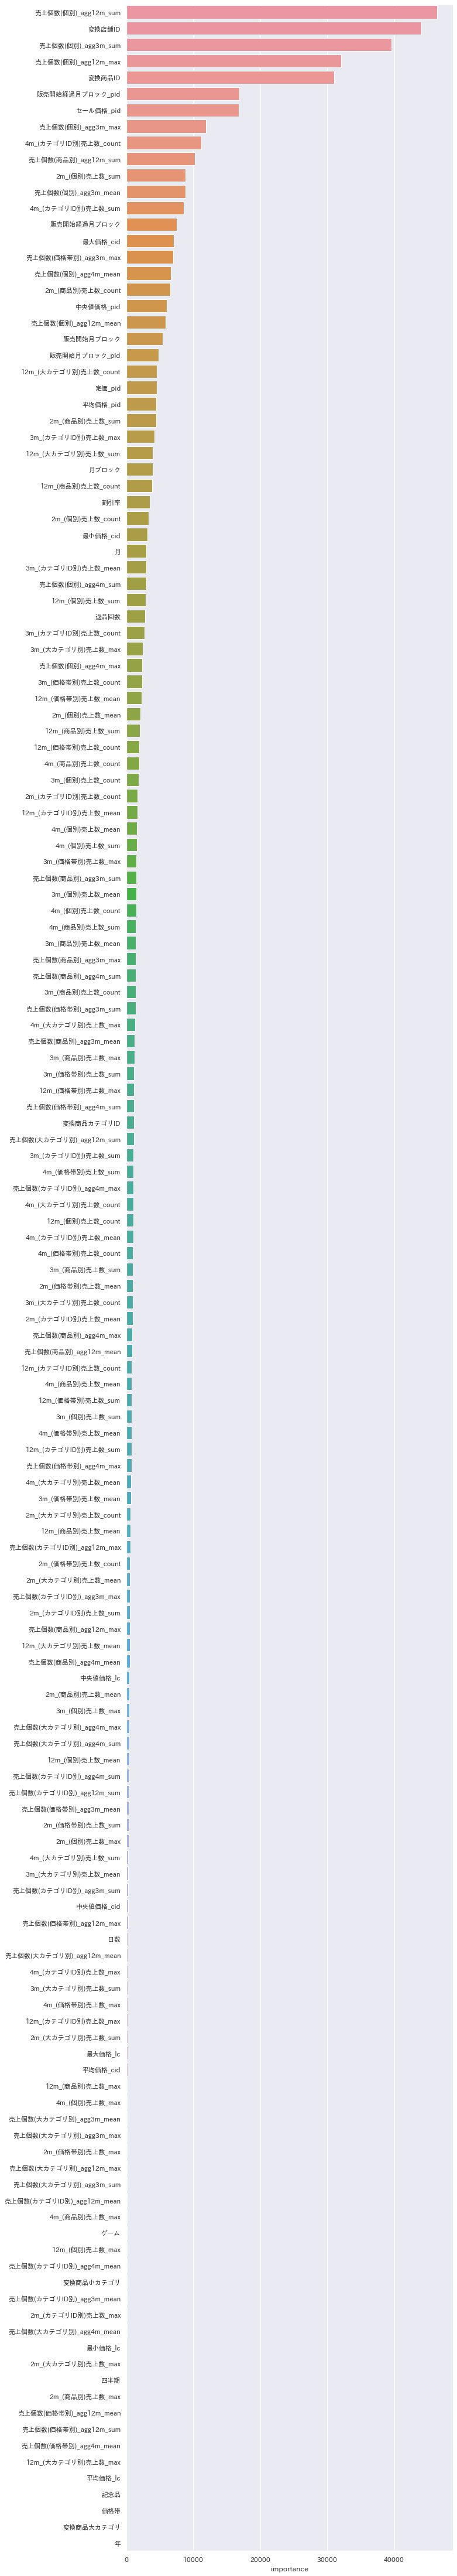

In [83]:
figure = plt.figure(figsize=(10, 80))
sns.set(font="IPAexGothic")
sns.barplot(x="importance", y=feature_importance.index, data=feature_importance)

In [84]:
feature_importance[feature_importance.importance > 0].shape

(152, 1)

In [85]:
feature_importance.shape

(156, 1)

In [86]:
use_col = feature_importance.index[:152]
y_pred,feature_importance = modeling(X_train[use_col],y_train,X_valid[use_col],y_valid,X_test[use_col],71)

[1]	training's l2: 2.67418	training's rmse: 1.63529	valid_1's l2: 15.7043	valid_1's rmse: 3.96286
Training until validation scores don't improve for 20 rounds.
[2]	training's l2: 2.5396	training's rmse: 1.59361	valid_1's l2: 15.6181	valid_1's rmse: 3.95197
[3]	training's l2: 2.41924	training's rmse: 1.55539	valid_1's l2: 15.494	valid_1's rmse: 3.93624
[4]	training's l2: 2.3055	training's rmse: 1.51839	valid_1's l2: 15.3956	valid_1's rmse: 3.92373
[5]	training's l2: 2.2034	training's rmse: 1.48438	valid_1's l2: 15.1013	valid_1's rmse: 3.88604
[6]	training's l2: 2.1114	training's rmse: 1.45306	valid_1's l2: 15.0116	valid_1's rmse: 3.87448
[7]	training's l2: 2.02661	training's rmse: 1.42359	valid_1's l2: 14.8578	valid_1's rmse: 3.85459
[8]	training's l2: 1.95029	training's rmse: 1.39653	valid_1's l2: 14.812	valid_1's rmse: 3.84864
[9]	training's l2: 1.87946	training's rmse: 1.37093	valid_1's l2: 14.6819	valid_1's rmse: 3.8317
[10]	training's l2: 1.81379	training's rmse: 1.34677	valid_1's 

### 検定無し

In [87]:
def train_test_split(dataset):
  train_dataset = dataset[(dataset['月ブロック'] >= 12) & (dataset['月ブロック'] < 22)]
  test_dataset = dataset[dataset['月ブロック'] == 23]

  X_train = train_dataset.drop('売上個数', axis=1)
  y_train = train_dataset['売上個数']
  X_test = test_dataset.drop(['売上個数'], axis=1)

  return X_train,y_train,X_test

In [88]:
X_train,y_train,X_test = train_test_split(dataset)

In [89]:
def modeling(X_train,y_train,X_test,seed):
  clf = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
                                importance_type='split', learning_rate=0.05, max_depth=-1,
                                min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
                                n_estimators=9999, n_jobs=-1, num_leaves=31, objective='regression',
                                random_state=seed, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000, subsample_freq=0,)
  clf.fit(X_train, y_train,)

  feature_importance = pd.DataFrame(
                                    clf.booster_.feature_importance(importance_type='gain'), 
                                    index = X_train.columns, columns=['importance']).sort_values(['importance'], 
                                    ascending=False
                                    )

  y_pred = clf.predict(X_test)

  return y_pred,feature_importance

In [90]:
y_pred,feature_importance = modeling(X_train,y_train,X_test,71)

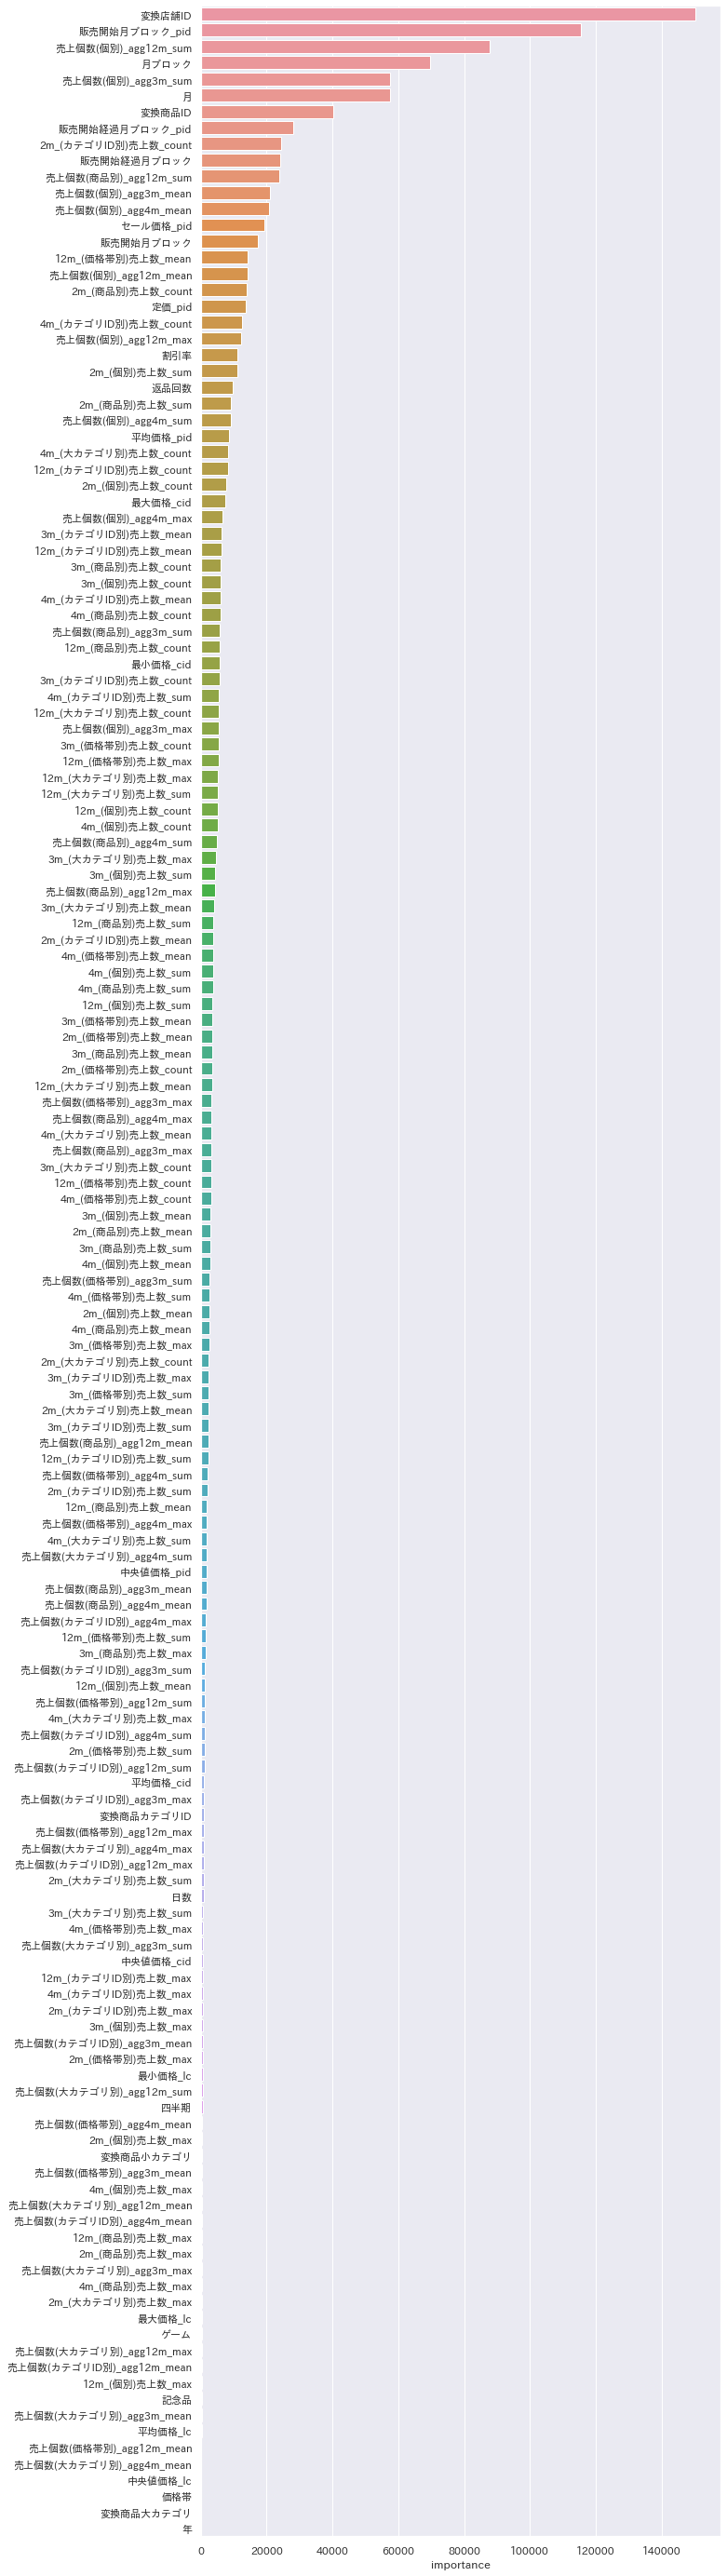

In [91]:
figure = plt.figure(figsize=(10, 50))
sns.set(font="IPAexGothic")
sns.barplot(x="importance", y=feature_importance.index, data=feature_importance)

In [92]:
y_pred2,feature_importance2 = modeling(X_train,y_train,X_test,99)

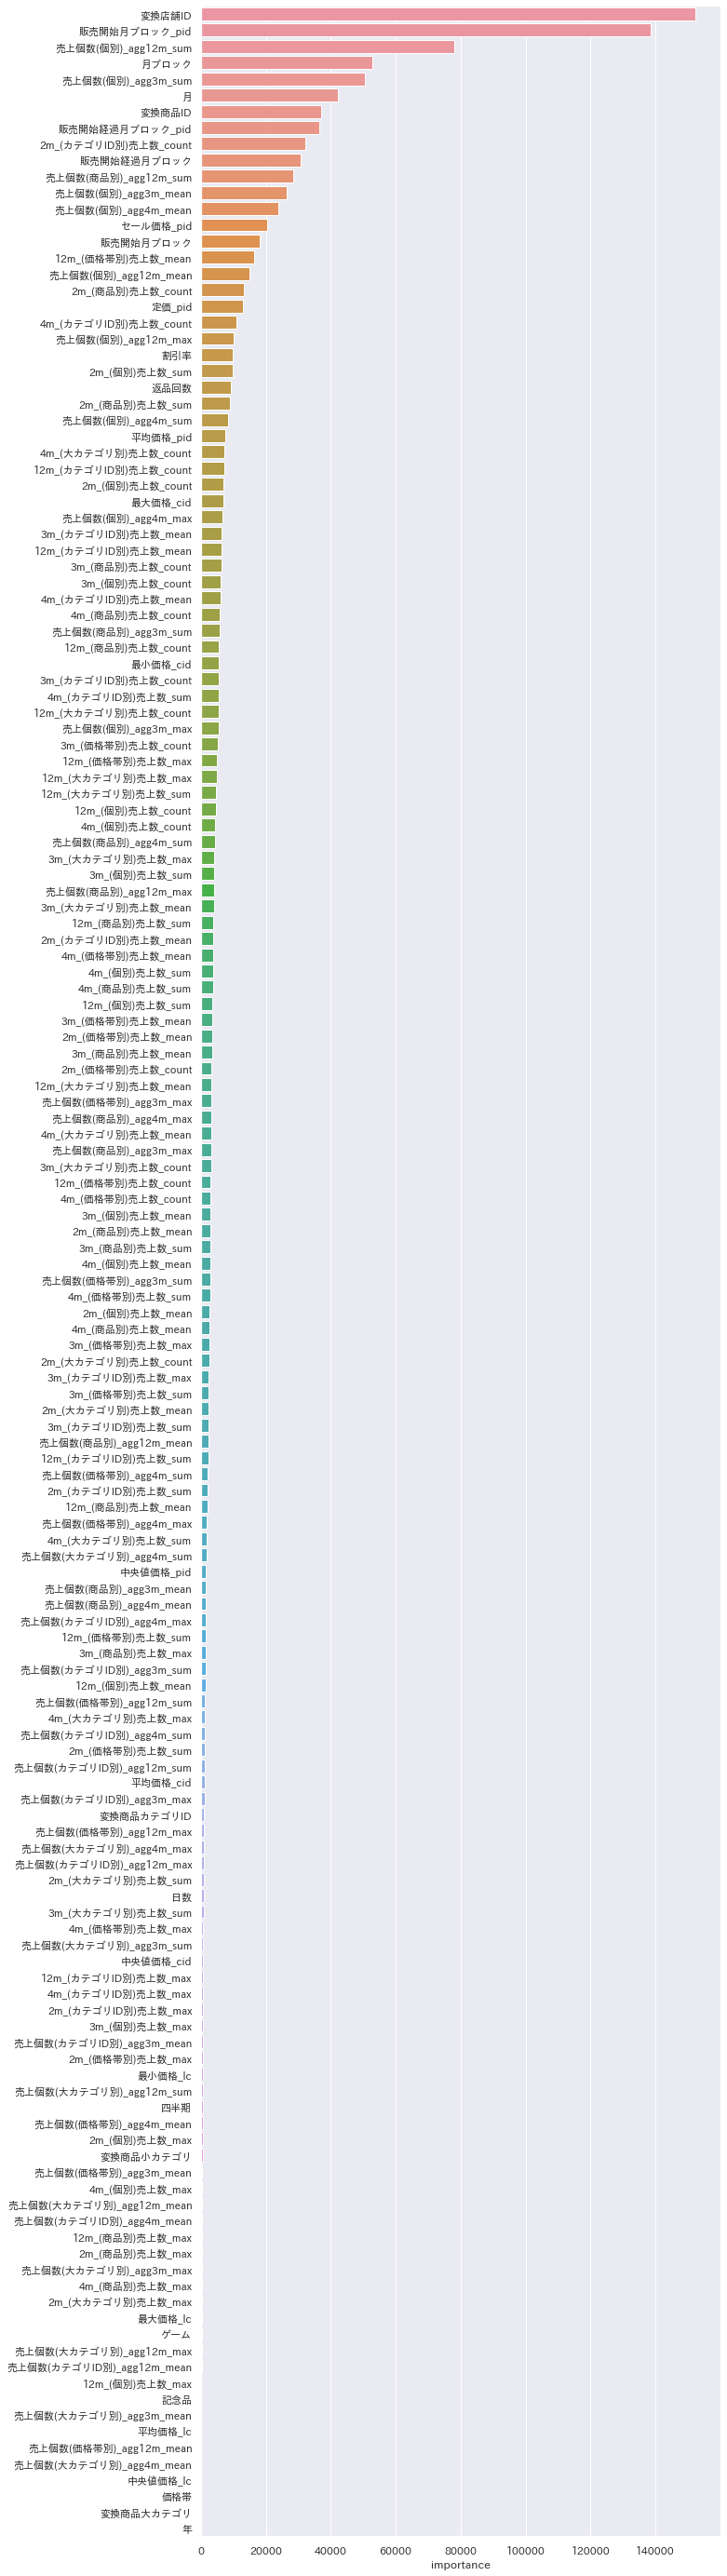

In [93]:
figure = plt.figure(figsize=(10, 50))
sns.set(font="IPAexGothic")
sns.barplot(x="importance", y=feature_importance.index, data=feature_importance2)

In [94]:
y_pred

array([ 1.16470103,  1.05407896,  1.84843167, ..., -0.1222498 ,
        0.11722217,  0.06497956])

In [95]:
y_pred2

array([1.1973148 , 1.01747571, 1.67752453, ..., 0.12610498, 0.11411674,
       0.03508169])

In [96]:
y_pred3,feature_importance3 = modeling(X_train,y_train,X_test,1)

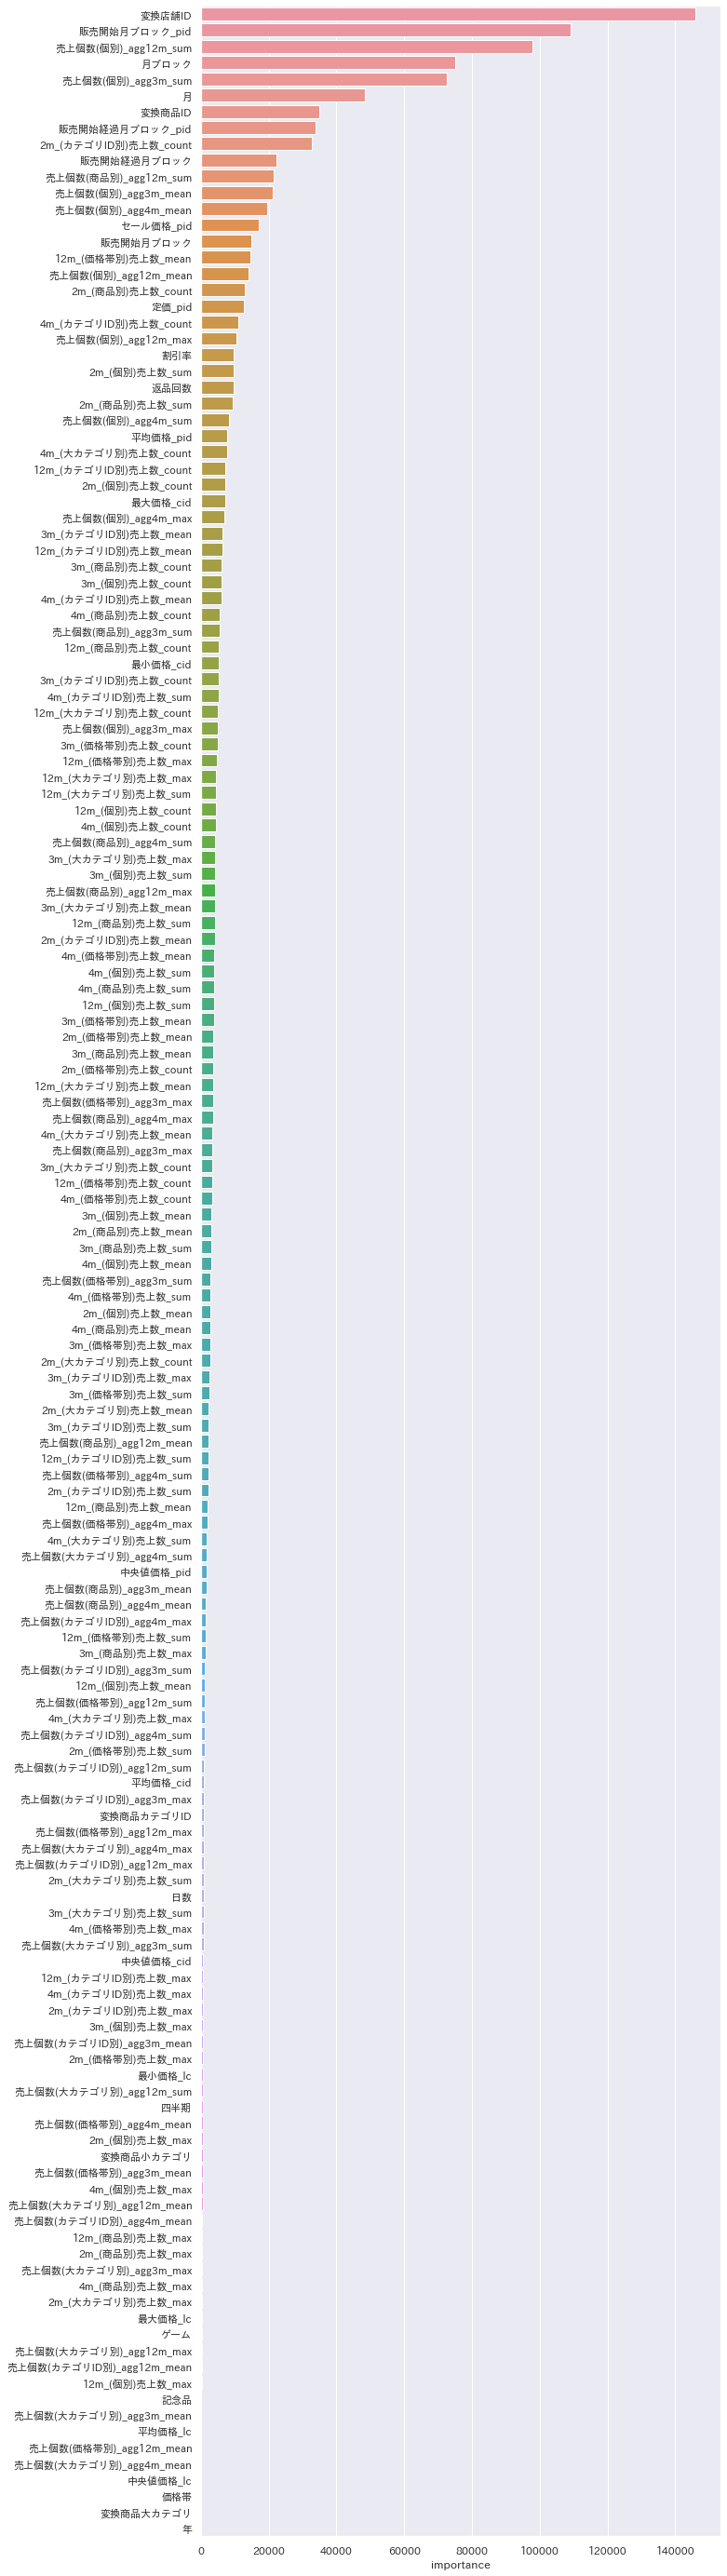

In [97]:
figure = plt.figure(figsize=(10, 50))
sns.set(font="IPAexGothic")
sns.barplot(x="importance", y=feature_importance.index, data=feature_importance3)

In [98]:
test['y1'] = y_pred
test['y2'] = y_pred2
test['y3'] = y_pred3
test['y'] = (test['y1']+test['y2']+test['y3'])/3

In [99]:
test.head()

,商品ID,店舗ID,月ブロック,y1,y2,y3,y
index,,,,,,,
0,1000001,0,23,1.16,1.20,1.17,1.18
1,1000001,1,23,1.05,1.02,1.10,1.06
2,1000001,2,23,1.85,1.68,1.99,1.84
3,1000001,3,23,3.68,3.87,3.38,3.65
4,1000001,4,23,9.60,9.56,8.79,9.32


In [100]:
test.loc[test['y'] < 0 ,'y'] = 0

# Submission

In [101]:
# sample_submissionの右側のカラムに予測値を代入する。
sub.iloc[:, -1] = test['y']
sub

,0,1
0,0,1.18
1,1,1.06
2,2,1.84
3,3,3.65
4,4,9.32
...,...,...
3055,3055,2.16
3056,3056,0.13
3057,3057,0.00
3058,3058,0.13


In [102]:
# 予測ファイルの生成
sub.to_csv('my_submission_20211003_2-4&12mlag.csv', index=False, header=False)